# DenseNet121

In [0]:
from google.colab import files
uploaded = files.upload()

Saving Input.mp4 to Input.mp4


In [0]:
ls

cat_dog.jpg  gradcam_Cat.jpg  guided_gradcam_Cat.jpg  image.jpg
datalab/     gradcam.jpg      guided_gradcam.jpg      original_input.jpg


In [0]:
!pip install keras-vis

In [0]:
from keras.applications.densenet import (
    DenseNet121, preprocess_input, decode_predictions)
from keras.preprocessing import image
from keras.layers.core import Lambda
from keras.models import Sequential
from tensorflow.python.framework import ops
import keras.backend as K
import tensorflow as tf
import numpy as np
import keras
import sys
import cv2

Using TensorFlow backend.


**Target function : ** 

The output of grad-cam will be pixels that contribute to the maximization of this target function. If for example you are interested in what maximizes category number 20, then zero out all the other categories. Below function does the same.

In [0]:
# We are taking category "bull_mustiff" which is having highest probability and finding one-hot encoding
# then doing elemntwise multiplication with the softmax layer fc1000 

def target_category_loss(x, category_index, nb_classes):
  
    # print('x :', x) ->  o/p :-  x :  Tensor("fc1000_7/Softmax:0", shape=(?, 1000), dtype=float32)
    # keras.backend.one_hot(indices, num_classes) -> Computes the one-hot representation of an integer tensor
    # tf.multiply -> element-wise multiplication
    # print('Shape of encoded vector : ', K.one_hot([category_index], nb_classes).shape) -> o/p :- Shape of encoded vector :  (1, 1000)
    
    return tf.multiply(x, K.one_hot([category_index], nb_classes))

In [0]:
def target_category_loss_output_shape(input_shape):
    
    # Returns output shape for the input tensor
    return input_shape

In [0]:
def normalize(x):
  
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

In [0]:
def load_image(path):
    img_path = path
    
    # `img` is a PIL image of size 224x224
    img = image.load_img(img_path, target_size=(224, 224))
    
    # `x` is a float32 Numpy array of shape (224, 224, 3)
    x = image.img_to_array(img)
    
    # We add a dimension to transform our array into a "batch" of size (1, 224, 224, 3)
    x = np.expand_dims(x, axis=0)
    #print('x:',x)
    
    # Finally we preprocess the batch (this does channel-wise color normalization)
    # normalize image by subtracting mean RGB values from the input image using a helper function preprocess_input
    x = preprocess_input(x)
   
    return x

In [0]:
def load_original_image(path):
    img_path = path
    
    # `img` is a PIL image of size 224x224
    img = image.load_img(img_path, target_size=(224, 224))
    
    # `x` is a float32 Numpy array of shape (224, 224, 3)
    x = image.img_to_array(img)
    
    # We add a dimension to transform our array into a "batch" of size (1, 224, 224, 3)
    #x = np.expand_dims(x, axis=0)
    
    return x

In [0]:
# Function returning modified model.
# Changes gradient function for all ReLu activations according to Guided Backpropagation.

def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                tf.cast(op.inputs[0] > 0., dtype)

In [0]:
def compile_saliency_function(model, activation_layer='conv5_block16_concat'):
    input_img = model.input
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output = layer_dict[activation_layer].output
    max_output = K.max(layer_output, axis=3)
    saliency = K.gradients(K.sum(max_output), input_img)[0]
    return K.function([input_img, K.learning_phase()], [saliency])

In [0]:
def modify_backprop(model, name):
    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': name}):

        # get layers that have an activation
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]

        # replace relu activation
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu

        # re-instanciate a new model
        new_model = DenseNet121(weights='imagenet')
    return new_model

In [0]:
def deprocess_image(x):
    '''
    Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    '''
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_dim_ordering() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
def grad_cam(input_model, image, oimage, category_index, layer_name):
    
    nb_classes = 1000
    
    # Normal functions are defined using the def keyword, in Python anonymous functions are defined using the lambda keyword.
    # lambda arguments: expression
    # Lambda functions can have any number of arguments but only one expression.
    
    target_layer = lambda x: target_category_loss(x, category_index, nb_classes)

    # Getting the output of the Last Fully Connected Layer - fc1000
    x = input_model.layers[-1].output
    
    # First argument is function to be evaluated and expects output shape from function
    x = Lambda(target_layer, output_shape=target_category_loss_output_shape)(x)
    # print('x::',x) -> o/p :- x:: Tensor("lambda_14/Mul:0", shape=(?, 1000), dtype=float32)
  
    # Instantiate a Model
    model = keras.models.Model(input_model.layers[0].input, x)
    
    # A new layer is added after fully connected layer
    
    # __________________________________________________________________________________________________
    # fc1000 (Dense)                  (None, 1000)         1025000     avg_pool[0][0]                   
    # __________________________________________________________________________________________________
    # lambda_15 (Lambda)              (None, 1000)         0           fc1000[0][0]
    
    #model.summary()
    
    # Sum of the values in a newly added lamda_15 layer
    loss = K.sum(model.layers[-1].output)
 
    # Find last Convolution layer -> "conv5_block16_concat" output 
    conv_output = [l for l in model.layers if l.name == layer_name][0].output
    
    # print('conv_output:', conv_output) -> o/p :- Tensor("conv5_block16_concat_7/concat:0", shape=(?, 7, 7, 1408), dtype=float32)
    
    
    # Compute the gradients of the target function (loss variable), with respect to the convolutional layer outputs (conv_output variable). 
    # This can be done effeciently with backpropagation.
    
    # Returns the gradients of loss w.r.t. conv_output variable
    grads = normalize(K.gradients(loss, conv_output)[0])
    
    # Instantiates a Keras function and returns output values as Numpy arrays
    gradient_function = K.function([model.layers[0].input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    
    print('output :', output.shape)
    print('grads_val :', grads_val.shape)

    # Use the convolutional layer output gradient image to create an importance map
    # taking the spatial average of each channel of the gradient image
    weights = np.mean(grads_val, axis = (0, 1))
    #print('weights:', weights)
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)
    #print('cam:', cam)
    
    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    # scaling the corresponding channel of the convolutional layer output
    cam = cv2.resize(cam, (224, 224))
    
    # Apply ReLU to keep only pixels those have a positive influence on the target function
    cam = np.maximum(cam, 0)
    
    heatmap = cam / np.max(cam)

    # Return to BGR [0..255] from the preprocessed image
    #image = image[0, :]
    #image -= np.min(image)
    #image = np.minimum(image, 255)
    #cv2.imwrite('image.jpg', oimage)
    
    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    
    # sum all the scaled channels to obtain the a heatmap
    cam = np.float32(cam) + np.float32(oimage)
    cam = 255 * cam / np.max(cam)
    
    return np.uint8(cam), heatmap
   

In [0]:
preprocessed_input = load_image('cat_dog.jpg')

original_input = load_original_image('cat_dog.jpg')
#cv2.imwrite('original_input.jpg', original_input)

#print('preprocessed_input:',preprocessed_input)

#cv2.imwrite('proprocess.jpg', preprocessed_input)

"""Creating keras model instance.

    Model can be
     - Trained here
     - Loaded with load_model
     - Loaded from keras.applications
"""
model = DenseNet121(weights='imagenet')

#model.summary()

predictions = model.predict(preprocessed_input)
top_1 = decode_predictions(predictions)[0][0]
print('Predicted class:')
print('%s (%s) with probability %.2f' % (top_1[1], top_1[0], top_1[2]))

FileNotFoundError: ignored

In [0]:
print('Prediction array shape:', predictions.shape)
topK = 5

#Decodes the prediction of an ImageNet model
decoded = decode_predictions(predictions, top=topK)[0]
print('Predicted:', decoded)

# predicted class probability - bull_mastiff
ind = np.unravel_index(np.argmax(predictions, axis=None), predictions.shape)
print('Predicted class probability:', predictions[ind])

Prediction array shape: (1, 1000)
Predicted: [('n02108422', 'bull_mastiff', 0.66426307), ('n02108089', 'boxer', 0.2106329), ('n02109525', 'Saint_Bernard', 0.029169599), ('n02123159', 'tiger_cat', 0.013567614), ('n02093428', 'American_Staffordshire_terrier', 0.012470502)]
Predicted class probability: 0.66426307


In [0]:
# np.argmax -> Returns the indices of the maximum values
predicted_class = 282
#predicted_class = 242
# print(predicted_class) -> predicted_class = 243

#cam, heatmap = grad_cam(model, preprocessed_input, predicted_class, "conv5_block16_concat")
cam, heatmap = grad_cam(model, preprocessed_input, original_input, predicted_class, "conv5_block16_concat")

cv2.imwrite("gradcam.jpg", cam)

output : (7, 7, 1024)
grads_val : (7, 7, 1024)


True

In [0]:
register_gradient()
guided_model = modify_backprop(model, 'GuidedBackProp')
saliency_fn = compile_saliency_function(guided_model)
saliency = saliency_fn([preprocessed_input, 0])
gradcam = saliency[0] * heatmap[..., np.newaxis]
cv2.imwrite("guided_gradcam.jpg", deprocess_image(gradcam))

True

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Text(0.5,1,'Grad-CAM for Cat')

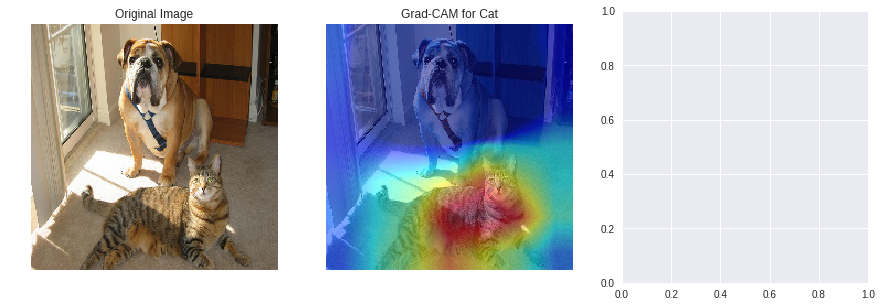

In [0]:
from matplotlib import pyplot as plt
from skimage import io
from skimage.transform import resize
fig, axs = plt.subplots(1,3,figsize=(15,5))

img = io.imread('cat_dog.jpg')
image = resize(img, (224, 224))
axs[0].imshow(image)
axs[0].axis('off')
axs[0].set_title('Original Image')

img = io.imread('gradcam.jpg')
axs[1].imshow(img)
axs[1].axis('off')
axs[1].set_title('Grad-CAM for Cat')


In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_21 (ZeroPadding2 (None, 230, 230, 3)  0           input_11[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_21[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

conv5_block10_1_relu (Activatio (None, 7, 7, 128)    0           conv5_block10_1_bn[0][0]         
__________________________________________________________________________________________________
conv5_block10_2_conv (Conv2D)   (None, 7, 7, 32)     36864       conv5_block10_1_relu[0][0]       
__________________________________________________________________________________________________
conv5_block10_concat (Concatena (None, 7, 7, 832)    0           conv5_block9_concat[0][0]        
                                                                 conv5_block10_2_conv[0][0]       
__________________________________________________________________________________________________
conv5_block11_0_bn (BatchNormal (None, 7, 7, 832)    3328        conv5_block10_concat[0][0]       
__________________________________________________________________________________________________
conv5_block11_0_relu (Activatio (None, 7, 7, 832)    0           conv5_block11_0_bn[0][0]         
__________

In [0]:
from google.colab import files
files.download('gradcam.jpg')
files.download('guided_gradcam.jpg')

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Text(0.5,1,'Guided Grad-CAM for Bull mastiff #Top prediction')

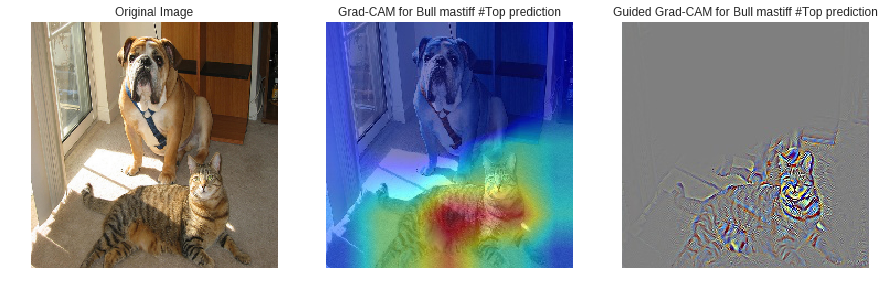

In [0]:
from matplotlib import pyplot as plt
from skimage import io
from skimage.transform import resize
fig, axs = plt.subplots(1,3,figsize=(15,5))

img = io.imread('cat_dog.jpg')
image = resize(img, (224, 224))
axs[0].imshow(image)
axs[0].axis('off')
axs[0].set_title('Original Image')

img = io.imread('gradcam.jpg')
axs[1].imshow(img)
axs[1].axis('off')
axs[1].set_title('Grad-CAM for Bull mastiff #Top prediction')

img = io.imread('guided_gradcam.jpg')
axs[2].imshow(img)
axs[2].axis('off')
axs[2].set_title('Guided Grad-CAM for Bull mastiff #Top prediction')

In [0]:
class_names = ['boxer', 'tiger_cat']
topK_ndx = []
imagenet_ndx = [] # indexes into the softmax entries of final layer
for i, name in enumerate(class_names):
    ndx = topK_names.index(name)
    topK_ndx.append(ndx)
    imagenet_ndx.append(np.argwhere(predictions[0] == topK_scores[ndx])[0][0])
print(imagenet_ndx)

[242, 282]


In [0]:
# np.argmax -> Returns the indices of the maximum values
predicted_class = 242 # Boxer

#cam, heatmap = grad_cam(model, preprocessed_input, predicted_class, "conv5_block16_concat")
cam, heatmap = grad_cam(model, preprocessed_input, original_input, predicted_class, "conv5_block16_concat")

cv2.imwrite("gradcam_Boxer.jpg", cam)

target_layer: <function grad_cam.<locals>.<lambda> at 0x7f4eaaccfae8>
output : (7, 7, 1024)
grads_val : (7, 7, 1024)


True

In [0]:
register_gradient()
guided_model = modify_backprop(model, 'GuidedBackProp')
saliency_fn = compile_saliency_function(guided_model)
saliency = saliency_fn([preprocessed_input, 0])
gradcam = saliency[0] * heatmap[..., np.newaxis]
cv2.imwrite("guided_gradcam_Boxer.jpg", deprocess_image(gradcam))

True

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Text(0.5,1,'Guided Grad-CAM for Boxer')

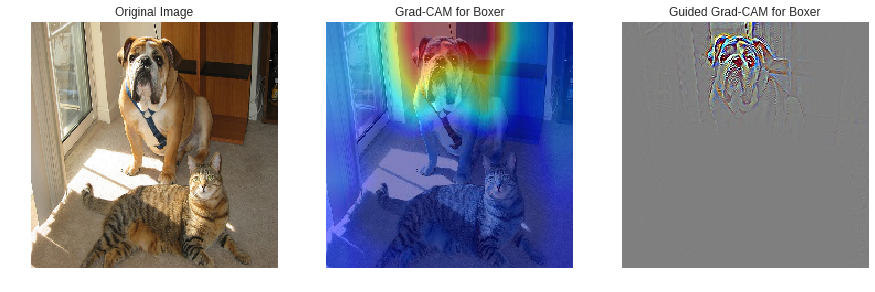

In [0]:
from matplotlib import pyplot as plt
from skimage import io
from skimage.transform import resize
fig, axs = plt.subplots(1,3,figsize=(15,5))

img = io.imread('cat_dog.jpg')
image = resize(img, (224, 224))
axs[0].imshow(image)
axs[0].axis('off')
axs[0].set_title('Original Image')

img = io.imread('gradcam_Boxer.jpg')
axs[1].imshow(img)
axs[1].axis('off')
axs[1].set_title('Grad-CAM for Boxer')

img = io.imread('guided_gradcam_Boxer.jpg')
axs[2].imshow(img)
axs[2].axis('off')
axs[2].set_title('Guided Grad-CAM for Boxer')

In [0]:
# np.argmax -> Returns the indices of the maximum values
predicted_class = 282 # tiger_cat

#cam, heatmap = grad_cam(model, preprocessed_input, predicted_class, "conv5_block16_concat")
cam, heatmap = grad_cam(model, preprocessed_input, original_input, predicted_class, "conv5_block16_concat")

cv2.imwrite("gradcam_Cat.jpg", cam)

True

In [0]:
register_gradient()
guided_model = modify_backprop(model, 'GuidedBackProp')
saliency_fn = compile_saliency_function(guided_model)
saliency = saliency_fn([preprocessed_input, 0])
gradcam = saliency[0] * heatmap[..., np.newaxis]
cv2.imwrite("guided_gradcam_Cat.jpg", deprocess_image(gradcam))

True

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Text(0.5,1,'Guided Grad-CAM for Tiger Cat')

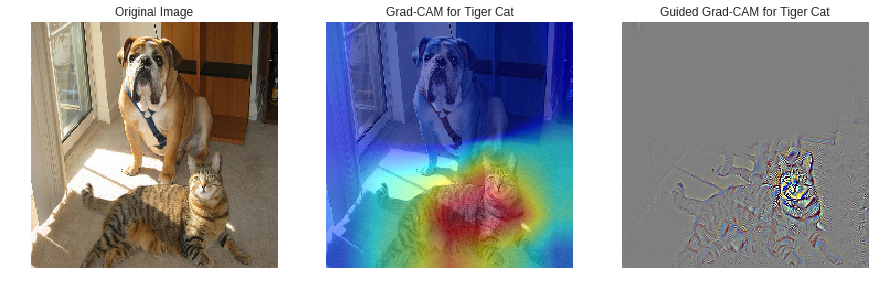

In [0]:
from matplotlib import pyplot as plt
from skimage import io
from skimage.transform import resize
fig, axs = plt.subplots(1,3,figsize=(15,5))

img = io.imread('cat_dog.jpg')
image = resize(img, (224, 224))
axs[0].imshow(image)
axs[0].axis('off')
axs[0].set_title('Original Image')

img = io.imread('gradcam_Cat.jpg')
axs[1].imshow(img)
axs[1].axis('off')
axs[1].set_title('Grad-CAM for Tiger Cat')

img = io.imread('guided_gradcam_Cat.jpg')
axs[2].imshow(img)
axs[2].axis('off')
axs[2].set_title('Guided Grad-CAM for Tiger Cat')

In [0]:
from google.colab import files
uploaded = files.upload()

Saving Input.mp4 to Input.mp4


In [0]:
!apt-get install ffmpeg
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2
!pip install -q tqdm
from tqdm import tqdm

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  dbus i965-va-driver libaacs0 libapparmor1 libasound2 libasound2-data libass9
  libasyncns0 libavc1394-0 libavcodec57 libavdevice57 libavfilter6
  libavformat57 libavresample3 libavutil55 libbdplus0 libbluray2
  libboost-filesystem1.62.0 libboost-system1.62.0 libbs2b0 libcaca0 libcairo2
  libcapnp-0.5.3 libcdio-cdda1 libcdio-paranoia1 libcdio13 libchromaprint1
  libcrystalhd3 libdbus-1-3 libdc1394-22 libdrm-amdgpu1 libdrm-common
  libdrm-intel1 libdrm-nouveau2 libdrm-radeon1 libdrm2 libegl1-mesa libelf1
  libfftw3-double3 libflac8 libflite1 libfribidi0 libgbm1 libgl1-mesa-dri
  libgl1-mesa-glx libglapi-mesa libgme0 libgraphite2-3 libgsm1 libharfbuzz0b
  libiec61883-0 libjack-jackd2-0 libllvm5.0 libmirclient9 libmircommon7
  libmircore1 libmirprotobuf3 libmp3lame0 libmpg123-0 libnuma1 libogg0
  libopenal-data libopenal1 libopencv-core3.1 l

Get:36 http://archive.ubuntu.com/ubuntu artful/main amd64 libtheora0 amd64 1.1.1+dfsg.1-14 [170 kB]
Get:37 http://archive.ubuntu.com/ubuntu artful/universe amd64 libtwolame0 amd64 0.3.13-2 [46.1 kB]
Get:38 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 libvorbis0a amd64 1.3.5-4ubuntu0.2 [86.5 kB]
Get:39 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 libvorbisenc2 amd64 1.3.5-4ubuntu0.2 [70.6 kB]
Get:40 http://archive.ubuntu.com/ubuntu artful/main amd64 libvpx4 amd64 1.6.1-3 [763 kB]
Get:41 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 libwavpack1 amd64 5.1.0-2ubuntu0.3 [76.3 kB]
Get:42 http://archive.ubuntu.com/ubuntu artful/main amd64 libwebp6 amd64 0.6.0-3 [181 kB]
Get:43 http://archive.ubuntu.com/ubuntu artful/main amd64 libwebpmux3 amd64 0.6.0-3 [20.0 kB]
Get:44 http://archive.ubuntu.com/ubuntu artful/universe amd64 libx264-148 amd64 2:0.148.2795+gitaaa9aa8-1 [604 kB]
Get:45 http://archive.ubuntu.com/ubuntu artful/universe amd64 libx265-130 amd6

Get:104 http://archive.ubuntu.com/ubuntu artful/main amd64 libasyncns0 amd64 0.8-6 [12.1 kB]
Get:105 http://archive.ubuntu.com/ubuntu artful/main amd64 libflac8 amd64 1.3.2-1 [213 kB]
Get:106 http://archive.ubuntu.com/ubuntu artful/main amd64 libsndfile1 amd64 1.0.28-4 [169 kB]
Get:107 http://archive.ubuntu.com/ubuntu artful/main amd64 libwrap0 amd64 7.6.q-26 [46.1 kB]
Get:108 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 libpulse0 amd64 1:10.0-2ubuntu3.1 [265 kB]
Get:109 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 libwayland-client0 amd64 1.14.0-1ubuntu0.1 [22.5 kB]
Get:110 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 libwayland-cursor0 amd64 1.14.0-1ubuntu0.1 [9,890 B]
Get:111 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 libwayland-server0 amd64 1.14.0-1ubuntu0.1 [28.5 kB]
Get:112 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 libgbm1 amd64 17.2.8-0ubuntu0~17.10.1 [24.4 kB]
Get:113 http://archive.ubuntu.com/ubuntu ar

Extracting templates from packages: 100%
Selecting previously unselected package libgsm1:amd64.
(Reading database ... 18396 files and directories currently installed.)
Preparing to unpack .../000-libgsm1_1.0.13-4_amd64.deb ...
Unpacking libgsm1:amd64 (1.0.13-4) ...
Selecting previously unselected package libogg0:amd64.
Preparing to unpack .../001-libogg0_1.3.2-1_amd64.deb ...
Unpacking libogg0:amd64 (1.3.2-1) ...
Selecting previously unselected package libxinerama1:amd64.
Preparing to unpack .../002-libxinerama1_2%3a1.1.3-1_amd64.deb ...
Unpacking libxinerama1:amd64 (2:1.1.3-1) ...
Selecting previously unselected package libxshmfence1:amd64.
Preparing to unpack .../003-libxshmfence1_1.2-1_amd64.deb ...
Unpacking libxshmfence1:amd64 (1.2-1) ...
Selecting previously unselected package libxxf86vm1:amd64.
Preparing to unpack .../004-libxxf86vm1_1%3a1.1.4-1_amd64.deb ...
Unpacking libxxf86vm1:amd64 (1:1.1.4-1) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpa

Unpacking libswresample2:amd64 (7:3.3.4-2) ...
Selecting previously unselected package libpixman-1-0:amd64.
Preparing to unpack .../031-libpixman-1-0_0.34.0-1_amd64.deb ...
Unpacking libpixman-1-0:amd64 (0.34.0-1) ...
Selecting previously unselected package libxcb-render0:amd64.
Preparing to unpack .../032-libxcb-render0_1.12-1ubuntu1_amd64.deb ...
Unpacking libxcb-render0:amd64 (1.12-1ubuntu1) ...
Selecting previously unselected package libxcb-shm0:amd64.
Preparing to unpack .../033-libxcb-shm0_1.12-1ubuntu1_amd64.deb ...
Unpacking libxcb-shm0:amd64 (1.12-1ubuntu1) ...
Selecting previously unselected package libcairo2:amd64.
Preparing to unpack .../034-libcairo2_1.14.10-1ubuntu1_amd64.deb ...
Unpacking libcairo2:amd64 (1.14.10-1ubuntu1) ...
Selecting previously unselected package libtheora0:amd64.
Preparing to unpack .../035-libtheora0_1.1.1+dfsg.1-14_amd64.deb ...
Unpacking libtheora0:amd64 (1.1.1+dfsg.1-14) ...
Selecting previously unselected package libtwolame0:amd64.
Preparing to 

Selecting previously unselected package libopenmpt0:amd64.
Preparing to unpack .../061-libopenmpt0_0.2.8760~beta27-1_amd64.deb ...
Unpacking libopenmpt0:amd64 (0.2.8760~beta27-1) ...
Selecting previously unselected package libssh-gcrypt-4:amd64.
Preparing to unpack .../062-libssh-gcrypt-4_0.7.5-1_amd64.deb ...
Unpacking libssh-gcrypt-4:amd64 (0.7.5-1) ...
Selecting previously unselected package libavformat57:amd64.
Preparing to unpack .../063-libavformat57_7%3a3.3.4-2_amd64.deb ...
Unpacking libavformat57:amd64 (7:3.3.4-2) ...
Selecting previously unselected package libavresample3:amd64.
Preparing to unpack .../064-libavresample3_7%3a3.3.4-2_amd64.deb ...
Unpacking libavresample3:amd64 (7:3.3.4-2) ...
Selecting previously unselected package libbs2b0:amd64.
Preparing to unpack .../065-libbs2b0_3.1.0+dfsg-2.2_amd64.deb ...
Unpacking libbs2b0:amd64 (3.1.0+dfsg-2.2) ...
Selecting previously unselected package libflite1:amd64.
Preparing to unpack .../066-libflite1_2.0.0-release-4_amd64.deb 

Selecting previously unselected package libpciaccess0:amd64.
Preparing to unpack .../090-libpciaccess0_0.13.4-1ubuntu1_amd64.deb ...
Unpacking libpciaccess0:amd64 (0.13.4-1ubuntu1) ...
Selecting previously unselected package libdrm-intel1:amd64.
Preparing to unpack .../091-libdrm-intel1_2.4.83-1_amd64.deb ...
Unpacking libdrm-intel1:amd64 (2.4.83-1) ...
Selecting previously unselected package libdrm-nouveau2:amd64.
Preparing to unpack .../092-libdrm-nouveau2_2.4.83-1_amd64.deb ...
Unpacking libdrm-nouveau2:amd64 (2.4.83-1) ...
Selecting previously unselected package libdrm-radeon1:amd64.
Preparing to unpack .../093-libdrm-radeon1_2.4.83-1_amd64.deb ...
Unpacking libdrm-radeon1:amd64 (2.4.83-1) ...
Selecting previously unselected package libllvm5.0:amd64.
Preparing to unpack .../094-libllvm5.0_1%3a5.0-3_amd64.deb ...
Unpacking libllvm5.0:amd64 (1:5.0-3) ...
Selecting previously unselected package libsensors4:amd64.
Preparing to unpack .../095-libsensors4_1%3a3.4.0-4_amd64.deb ...
Unpack

Selecting previously unselected package libxkbcommon0:amd64.
Preparing to unpack .../119-libxkbcommon0_0.7.1-2_amd64.deb ...
Unpacking libxkbcommon0:amd64 (0.7.1-2) ...
Selecting previously unselected package libmirclient9:amd64.
Preparing to unpack .../120-libmirclient9_0.28.0+17.10.20171011.1-0ubuntu1_amd64.deb ...
Unpacking libmirclient9:amd64 (0.28.0+17.10.20171011.1-0ubuntu1) ...
Selecting previously unselected package libxcb-xfixes0:amd64.
Preparing to unpack .../121-libxcb-xfixes0_1.12-1ubuntu1_amd64.deb ...
Unpacking libxcb-xfixes0:amd64 (1.12-1ubuntu1) ...
Selecting previously unselected package libegl1-mesa:amd64.
Preparing to unpack .../122-libegl1-mesa_17.2.8-0ubuntu0~17.10.1_amd64.deb ...
Unpacking libegl1-mesa:amd64 (17.2.8-0ubuntu0~17.10.1) ...
Selecting previously unselected package libwayland-egl1-mesa:amd64.
Preparing to unpack .../123-libwayland-egl1-mesa_17.2.8-0ubuntu0~17.10.1_amd64.deb ...
Unpacking libwayland-egl1-mesa:amd64 (17.2.8-0ubuntu0~17.10.1) ...
Selectin

Setting up libelf1:amd64 (0.170-0.1) ...
Setting up libcdio-cdda1:amd64 (0.83-4.2ubuntu1) ...
Setting up libsoxr0:amd64 (0.1.2-2) ...
Setting up libssh-gcrypt-4:amd64 (0.7.5-1) ...
Setting up libasound2-data (1.1.3-5) ...
Setting up libxshmfence1:amd64 (1.2-1) ...
Setting up libwayland-client0:amd64 (1.14.0-1ubuntu0.1) ...
Setting up xkb-data (2.19-1.1ubuntu1) ...
Setting up libcapnp-0.5.3:amd64 (0.5.3-2ubuntu2) ...
Setting up libbluray2:amd64 (1:1.0.1.deb1-2) ...
Setting up libvdpau1:amd64 (1.1.1-3ubuntu1) ...
Setting up libllvm5.0:amd64 (1:5.0-3) ...
Setting up libshine3:amd64 (3.1.1-1) ...
Setting up libtxc-dxtn-s2tc:amd64 (1.0+git20151227-2) ...
update-alternatives: using /usr/lib/x86_64-linux-gnu/s2tc/libtxc_dxtn.so to provide /usr/lib/x86_64-linux-gnu/libtxc_dxtn.so (libtxc-dxtn-x86_64-linux-gnu) in auto mode
Setting up libiec61883-0:amd64 (1.2.0-2) ...
Setting up libglapi-mesa:amd64 (17.2.8-0ubuntu0~17.10.1) ...
Setting up libspeex1:amd64 (1.2~rc1.2-1ubuntu1) ...
Setting up libf

Setting up libcaca0:amd64 (0.99.beta19-2build2~gcc5.2) ...
Setting up libmircore1:amd64 (0.28.0+17.10.20171011.1-0ubuntu1) ...
Setting up libtheora0:amd64 (1.1.1+dfsg.1-14) ...
Setting up libva-x11-1:amd64 (1.8.3-2) ...
Setting up libavutil55:amd64 (7:3.3.4-2) ...
Setting up libdrm-amdgpu1:amd64 (2.4.83-1) ...
Setting up mesa-vdpau-drivers:amd64 (17.2.8-0ubuntu0~17.10.1) ...
Setting up libgbm1:amd64 (17.2.8-0ubuntu0~17.10.1) ...
Setting up libass9:amd64 (1:0.13.7-2) ...
Setting up libgl1-mesa-dri:amd64 (17.2.8-0ubuntu0~17.10.1) ...
Setting up libswresample2:amd64 (7:3.3.4-2) ...
Setting up libsndfile1:amd64 (1.0.28-4) ...
Setting up i965-va-driver:amd64 (1.8.3-1ubuntu1) ...
Setting up libgl1-mesa-glx:amd64 (17.2.8-0ubuntu0~17.10.1) ...
update-alternatives: using /usr/lib/x86_64-linux-gnu/mesa/ld.so.conf to provide /etc/ld.so.conf.d/x86_64-linux-gnu_GL.conf (x86_64-linux-gnu_gl_conf) in auto mode
Setting up libswscale4:amd64 (7:3.3.4-2) ...
Setting up mesa-va-drivers:amd64 (17.2.8-0ubun

In [0]:

video_inp = 'Input.mp4'
video_out = 'Animals_out.mp4'

video_reader = cv2.VideoCapture(video_inp)

nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))

video_writer = cv2.VideoWriter(video_out,
                               cv2.VideoWriter_fourcc(*'MP4V'), 
                               20.0, 
                               (frame_w, frame_h))

for i in tqdm(range(nb_frames)):
    ret, image = video_reader.read()
    if ret == True:
      input_image = cv2.resize(image, (224, 224))
      original_image = cv2.resize(image, (224, 224))
      input_image = input_image[:,:,::-1]     """ convert from RGB of PIL to BGR of OpenCV """
      input_image = np.expand_dims(input_image, 0)
      input_image = input_image.astype(np.float32)
      input_image = preprocess_input(input_image)
      predictions = model.predict(input_image)
      top_1 = decode_predictions(predictions)[0][0]
      print('Predicted class:')
      print('%s (%s) with probability %.2f' % (top_1[1], top_1[0], top_1[2]))
      
      predicted_class = np.argmax(predictions)
      
      cam, heatmap = grad_cam(model, input_image, original_image, predicted_class, "conv5_block16_concat")
      cam = cv2.resize(cam, (1280, 1280))
      cv2.imwrite('Image' + str(i) + '.jpg', cam)
      video_writer.write(cam)

video_reader.release()
video_writer.release()



  0%|          | 0/481 [00:00<?, ?it/s]

40960/35363 [==================================] - 0s 1us/step
Predicted class:
tiger (n02129604) with probability 0.91


  0%|          | 1/481 [00:05<45:10,  5.65s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.90


  0%|          | 2/481 [00:07<31:39,  3.97s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.91


  1%|          | 3/481 [00:10<27:18,  3.43s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.92


  1%|          | 4/481 [00:12<25:03,  3.15s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.91


  1%|          | 5/481 [00:15<23:51,  3.01s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.89


  1%|          | 6/481 [00:17<23:08,  2.92s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.90


  1%|▏         | 7/481 [00:20<22:37,  2.86s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.93


  2%|▏         | 8/481 [00:22<22:08,  2.81s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.93


  2%|▏         | 9/481 [00:25<21:52,  2.78s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.91


  2%|▏         | 10/481 [00:27<21:36,  2.75s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.91


  2%|▏         | 11/481 [00:30<21:24,  2.73s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.92


  2%|▏         | 12/481 [00:32<21:18,  2.73s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.90


  3%|▎         | 13/481 [00:35<21:09,  2.71s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.90


  3%|▎         | 14/481 [00:37<21:01,  2.70s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.90


  3%|▎         | 15/481 [00:40<20:54,  2.69s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.91


  3%|▎         | 16/481 [00:42<20:47,  2.68s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.88


  4%|▎         | 17/481 [00:45<20:41,  2.68s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.88


  4%|▎         | 18/481 [00:48<20:37,  2.67s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.87


  4%|▍         | 19/481 [00:50<20:33,  2.67s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.87


  4%|▍         | 20/481 [00:53<20:29,  2.67s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.90


  4%|▍         | 21/481 [00:55<20:26,  2.67s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.87


  5%|▍         | 22/481 [00:58<20:22,  2.66s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.88


  5%|▍         | 23/481 [01:01<20:19,  2.66s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.89


  5%|▍         | 24/481 [01:04<20:23,  2.68s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.90


  5%|▌         | 25/481 [01:06<20:20,  2.68s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.90


  5%|▌         | 26/481 [01:09<20:17,  2.68s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.89


  6%|▌         | 27/481 [01:12<20:13,  2.67s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.86


  6%|▌         | 28/481 [01:14<20:11,  2.67s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.85


  6%|▌         | 29/481 [01:17<20:07,  2.67s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.89


  6%|▌         | 30/481 [01:20<20:05,  2.67s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.89


  6%|▋         | 31/481 [01:22<20:02,  2.67s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.89


  7%|▋         | 32/481 [01:25<20:00,  2.67s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.87


  7%|▋         | 33/481 [01:28<19:56,  2.67s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.89


  7%|▋         | 34/481 [01:30<19:54,  2.67s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.92


  7%|▋         | 35/481 [01:33<19:52,  2.67s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.91


  7%|▋         | 36/481 [01:36<19:50,  2.68s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.90


  8%|▊         | 37/481 [01:38<19:47,  2.68s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.88


  8%|▊         | 38/481 [01:41<19:45,  2.68s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.90


  8%|▊         | 39/481 [01:44<19:43,  2.68s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.91


  8%|▊         | 40/481 [01:47<19:41,  2.68s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.89


  9%|▊         | 41/481 [01:49<19:39,  2.68s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.90


  9%|▊         | 42/481 [01:52<19:37,  2.68s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.89


  9%|▉         | 43/481 [01:55<19:35,  2.68s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.88


  9%|▉         | 44/481 [01:58<19:34,  2.69s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.90


  9%|▉         | 45/481 [02:01<19:33,  2.69s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.88


 10%|▉         | 46/481 [02:03<19:31,  2.69s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.90


 10%|▉         | 47/481 [02:06<19:29,  2.69s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.91


 10%|▉         | 48/481 [02:09<19:27,  2.70s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.92


 10%|█         | 49/481 [02:12<19:25,  2.70s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.91


 10%|█         | 50/481 [02:14<19:23,  2.70s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.84


 11%|█         | 51/481 [02:17<19:21,  2.70s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.88


 11%|█         | 52/481 [02:20<19:19,  2.70s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.88


 11%|█         | 53/481 [02:23<19:17,  2.70s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.92


 11%|█         | 54/481 [02:26<19:15,  2.71s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.91


 11%|█▏        | 55/481 [02:28<19:13,  2.71s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.92


 12%|█▏        | 56/481 [02:31<19:12,  2.71s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.91


 12%|█▏        | 57/481 [02:34<19:10,  2.71s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.90


 12%|█▏        | 58/481 [02:37<19:08,  2.72s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.87


 12%|█▏        | 59/481 [02:40<19:06,  2.72s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.90


 12%|█▏        | 60/481 [02:43<19:05,  2.72s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.93


 13%|█▎        | 61/481 [02:46<19:03,  2.72s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.95


 13%|█▎        | 62/481 [02:49<19:02,  2.73s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.92


 13%|█▎        | 63/481 [02:51<19:00,  2.73s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.95


 13%|█▎        | 64/481 [02:54<18:58,  2.73s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.95


 14%|█▎        | 65/481 [02:57<18:57,  2.73s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.96


 14%|█▎        | 66/481 [03:00<18:56,  2.74s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.95


 14%|█▍        | 67/481 [03:03<18:54,  2.74s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.95


 14%|█▍        | 68/481 [03:06<18:53,  2.74s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.94


 14%|█▍        | 69/481 [03:09<18:51,  2.75s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.95


 15%|█▍        | 70/481 [03:12<18:50,  2.75s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.95


 15%|█▍        | 71/481 [03:15<18:49,  2.76s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.95


 15%|█▍        | 72/481 [03:18<18:48,  2.76s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.93


 15%|█▌        | 73/481 [03:21<18:46,  2.76s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.94


 15%|█▌        | 74/481 [03:24<18:44,  2.76s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.95


 16%|█▌        | 75/481 [03:27<18:43,  2.77s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.96


 16%|█▌        | 76/481 [03:30<18:43,  2.77s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.95


 16%|█▌        | 77/481 [03:33<18:42,  2.78s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.95


 16%|█▌        | 78/481 [03:37<18:41,  2.78s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.95


 16%|█▋        | 79/481 [03:39<18:39,  2.78s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.96


 17%|█▋        | 80/481 [03:43<18:37,  2.79s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.96


 17%|█▋        | 81/481 [03:46<18:36,  2.79s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.95


 17%|█▋        | 82/481 [03:49<18:35,  2.80s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.95


 17%|█▋        | 83/481 [03:52<18:34,  2.80s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.94


 17%|█▋        | 84/481 [03:55<18:32,  2.80s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.93


 18%|█▊        | 85/481 [03:58<18:31,  2.81s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.95


 18%|█▊        | 86/481 [04:01<18:30,  2.81s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.93


 18%|█▊        | 87/481 [04:04<18:28,  2.81s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.93


 18%|█▊        | 88/481 [04:07<18:26,  2.82s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.94


 19%|█▊        | 89/481 [04:10<18:25,  2.82s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.90


 19%|█▊        | 90/481 [04:14<18:24,  2.82s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.91


 19%|█▉        | 91/481 [04:17<18:22,  2.83s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.91


 19%|█▉        | 92/481 [04:20<18:21,  2.83s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.92


 19%|█▉        | 93/481 [04:23<18:20,  2.84s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.94


 20%|█▉        | 94/481 [04:26<18:18,  2.84s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.94


 20%|█▉        | 95/481 [04:29<18:16,  2.84s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.91


 20%|█▉        | 96/481 [04:33<18:15,  2.85s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.89


 20%|██        | 97/481 [04:36<18:14,  2.85s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.91


 20%|██        | 98/481 [04:39<18:12,  2.85s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.90


 21%|██        | 99/481 [04:42<18:10,  2.85s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.93


 21%|██        | 100/481 [04:45<18:08,  2.86s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.91


 21%|██        | 101/481 [04:48<18:07,  2.86s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.90


 21%|██        | 102/481 [04:52<18:05,  2.86s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.92


 21%|██▏       | 103/481 [04:55<18:03,  2.87s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.90


 22%|██▏       | 104/481 [04:58<18:02,  2.87s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.91


 22%|██▏       | 105/481 [05:01<18:00,  2.87s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.92


 22%|██▏       | 106/481 [05:04<17:58,  2.88s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.93


 22%|██▏       | 107/481 [05:07<17:56,  2.88s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.94


 22%|██▏       | 108/481 [05:11<17:54,  2.88s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.94


 23%|██▎       | 109/481 [05:14<17:52,  2.88s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.95


 23%|██▎       | 110/481 [05:17<17:51,  2.89s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.92


 23%|██▎       | 111/481 [05:21<17:50,  2.89s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.93


 23%|██▎       | 112/481 [05:24<17:48,  2.90s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.94


 23%|██▎       | 113/481 [05:27<17:47,  2.90s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.93


 24%|██▎       | 114/481 [05:30<17:45,  2.90s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.96


 24%|██▍       | 115/481 [05:34<17:43,  2.91s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.94


 24%|██▍       | 116/481 [05:37<17:42,  2.91s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.94


 24%|██▍       | 117/481 [05:40<17:40,  2.91s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.94


 25%|██▍       | 118/481 [05:44<17:38,  2.92s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.94


 25%|██▍       | 119/481 [05:47<17:37,  2.92s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.95


 25%|██▍       | 120/481 [05:50<17:35,  2.92s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.95


 25%|██▌       | 121/481 [05:54<17:33,  2.93s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.96


 25%|██▌       | 122/481 [05:57<17:31,  2.93s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.93


 26%|██▌       | 123/481 [06:00<17:29,  2.93s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.95


 26%|██▌       | 124/481 [06:04<17:28,  2.94s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.93


 26%|██▌       | 125/481 [06:07<17:26,  2.94s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.92


 26%|██▌       | 126/481 [06:10<17:24,  2.94s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.95


 26%|██▋       | 127/481 [06:14<17:22,  2.95s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.95


 27%|██▋       | 128/481 [06:17<17:21,  2.95s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.93


 27%|██▋       | 129/481 [06:20<17:19,  2.95s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.89


 27%|██▋       | 130/481 [06:24<17:17,  2.96s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.91


 27%|██▋       | 131/481 [06:27<17:16,  2.96s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.85


 27%|██▋       | 132/481 [06:31<17:14,  2.96s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.83


 28%|██▊       | 133/481 [06:34<17:12,  2.97s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.88


 28%|██▊       | 134/481 [06:37<17:10,  2.97s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.87


 28%|██▊       | 135/481 [06:41<17:08,  2.97s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.86


 28%|██▊       | 136/481 [06:44<17:06,  2.98s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.88


 28%|██▊       | 137/481 [06:48<17:05,  2.98s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.85


 29%|██▊       | 138/481 [06:51<17:03,  2.98s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.88


 29%|██▉       | 139/481 [06:55<17:01,  2.99s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.86


 29%|██▉       | 140/481 [06:58<17:00,  2.99s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.89


 29%|██▉       | 141/481 [07:02<16:57,  2.99s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.88


 30%|██▉       | 142/481 [07:05<16:56,  3.00s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.88


 30%|██▉       | 143/481 [07:09<16:54,  3.00s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.87


 30%|██▉       | 144/481 [07:12<16:51,  3.00s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.82


 30%|███       | 145/481 [07:15<16:49,  3.01s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.85


 30%|███       | 146/481 [07:19<16:47,  3.01s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.81


 31%|███       | 147/481 [07:22<16:45,  3.01s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.83


 31%|███       | 148/481 [07:25<16:43,  3.01s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.79


 31%|███       | 149/481 [07:29<16:41,  3.02s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.78


 31%|███       | 150/481 [07:33<16:39,  3.02s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.82


 31%|███▏      | 151/481 [07:36<16:38,  3.02s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.79


 32%|███▏      | 152/481 [07:40<16:36,  3.03s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.82


 32%|███▏      | 153/481 [07:43<16:34,  3.03s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.81


 32%|███▏      | 154/481 [07:47<16:32,  3.04s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.81


 32%|███▏      | 155/481 [07:51<16:30,  3.04s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.78


 32%|███▏      | 156/481 [07:54<16:28,  3.04s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.79


 33%|███▎      | 157/481 [07:58<16:26,  3.05s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.82


 33%|███▎      | 158/481 [08:01<16:24,  3.05s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.84


 33%|███▎      | 159/481 [08:05<16:23,  3.05s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.85


 33%|███▎      | 160/481 [08:08<16:20,  3.06s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.88


 33%|███▎      | 161/481 [08:12<16:18,  3.06s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.90


 34%|███▎      | 162/481 [08:16<16:16,  3.06s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.88


 34%|███▍      | 163/481 [08:19<16:14,  3.06s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.87


 34%|███▍      | 164/481 [08:23<16:12,  3.07s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
tiger (n02129604) with probability 0.90


 34%|███▍      | 165/481 [08:26<16:10,  3.07s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.97


 35%|███▍      | 166/481 [08:30<16:08,  3.07s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.97


 35%|███▍      | 167/481 [08:33<16:06,  3.08s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.92


 35%|███▍      | 168/481 [08:37<16:03,  3.08s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.97


 35%|███▌      | 169/481 [08:40<16:01,  3.08s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.91


 35%|███▌      | 170/481 [08:44<15:59,  3.08s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.93


 36%|███▌      | 171/481 [08:47<15:57,  3.09s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.93


 36%|███▌      | 172/481 [08:51<15:54,  3.09s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.92


 36%|███▌      | 173/481 [08:55<15:52,  3.09s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.92


 36%|███▌      | 174/481 [08:58<15:50,  3.10s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.92


 36%|███▋      | 175/481 [09:02<15:48,  3.10s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.89


 37%|███▋      | 176/481 [09:05<15:46,  3.10s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.87


 37%|███▋      | 177/481 [09:09<15:43,  3.10s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.76


 37%|███▋      | 178/481 [09:13<15:41,  3.11s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.89


 37%|███▋      | 179/481 [09:16<15:39,  3.11s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.90


 37%|███▋      | 180/481 [09:20<15:36,  3.11s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.97


 38%|███▊      | 181/481 [09:23<15:34,  3.12s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.97


 38%|███▊      | 182/481 [09:27<15:32,  3.12s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.96


 38%|███▊      | 183/481 [09:31<15:30,  3.12s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.95


 38%|███▊      | 184/481 [09:34<15:27,  3.12s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.81


 38%|███▊      | 185/481 [09:38<15:25,  3.13s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.91


 39%|███▊      | 186/481 [09:42<15:23,  3.13s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.91


 39%|███▉      | 187/481 [09:45<15:20,  3.13s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.89


 39%|███▉      | 188/481 [09:49<15:18,  3.13s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.96


 39%|███▉      | 189/481 [09:52<15:16,  3.14s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.97


 40%|███▉      | 190/481 [09:56<15:13,  3.14s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.98


 40%|███▉      | 191/481 [10:00<15:11,  3.14s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.99


 40%|███▉      | 192/481 [10:03<15:08,  3.14s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.97


 40%|████      | 193/481 [10:07<15:06,  3.15s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.97


 40%|████      | 194/481 [10:11<15:04,  3.15s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.97


 41%|████      | 195/481 [10:14<15:01,  3.15s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.95


 41%|████      | 196/481 [10:18<14:59,  3.16s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.94


 41%|████      | 197/481 [10:22<14:57,  3.16s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.97


 41%|████      | 198/481 [10:25<14:54,  3.16s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.97


 41%|████▏     | 199/481 [10:29<14:52,  3.16s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.96


 42%|████▏     | 200/481 [10:33<14:49,  3.17s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.97


 42%|████▏     | 201/481 [10:37<14:47,  3.17s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.97


 42%|████▏     | 202/481 [10:40<14:45,  3.17s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.97


 42%|████▏     | 203/481 [10:44<14:42,  3.18s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.96


 42%|████▏     | 204/481 [10:48<14:40,  3.18s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.95


 43%|████▎     | 205/481 [10:52<14:37,  3.18s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.96


 43%|████▎     | 206/481 [10:55<14:35,  3.18s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.96


 43%|████▎     | 207/481 [10:59<14:33,  3.19s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.96


 43%|████▎     | 208/481 [11:03<14:30,  3.19s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.96


 43%|████▎     | 209/481 [11:07<14:28,  3.19s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.97


 44%|████▎     | 210/481 [11:10<14:25,  3.19s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.97


 44%|████▍     | 211/481 [11:14<14:23,  3.20s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.97


 44%|████▍     | 212/481 [11:18<14:20,  3.20s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.98


 44%|████▍     | 213/481 [11:21<14:17,  3.20s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.99


 44%|████▍     | 214/481 [11:25<14:15,  3.20s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.98


 45%|████▍     | 215/481 [11:29<14:12,  3.21s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.99


 45%|████▍     | 216/481 [11:33<14:10,  3.21s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.98


 45%|████▌     | 217/481 [11:37<14:08,  3.21s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.97


 45%|████▌     | 218/481 [11:41<14:05,  3.22s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.98


 46%|████▌     | 219/481 [11:44<14:03,  3.22s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.98


 46%|████▌     | 220/481 [11:48<14:00,  3.22s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.98


 46%|████▌     | 221/481 [11:52<13:58,  3.22s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.98


 46%|████▌     | 222/481 [11:56<13:55,  3.23s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.97


 46%|████▋     | 223/481 [11:59<13:52,  3.23s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.96


 47%|████▋     | 224/481 [12:03<13:50,  3.23s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.91


 47%|████▋     | 225/481 [12:07<13:47,  3.23s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.88


 47%|████▋     | 226/481 [12:11<13:45,  3.24s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.89


 47%|████▋     | 227/481 [12:15<13:42,  3.24s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.92


 47%|████▋     | 228/481 [12:19<13:40,  3.24s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.89


 48%|████▊     | 229/481 [12:22<13:37,  3.24s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.94


 48%|████▊     | 230/481 [12:26<13:35,  3.25s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.95


 48%|████▊     | 231/481 [12:30<13:32,  3.25s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.95


 48%|████▊     | 232/481 [12:34<13:30,  3.25s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.91


 48%|████▊     | 233/481 [12:38<13:27,  3.26s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.93


 49%|████▊     | 234/481 [12:42<13:24,  3.26s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.98


 49%|████▉     | 235/481 [12:46<13:22,  3.26s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.98


 49%|████▉     | 236/481 [12:50<13:19,  3.26s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.98


 49%|████▉     | 237/481 [12:54<13:17,  3.27s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.99


 49%|████▉     | 238/481 [12:58<13:14,  3.27s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.93


 50%|████▉     | 239/481 [13:02<13:12,  3.27s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.96


 50%|████▉     | 240/481 [13:06<13:09,  3.28s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.95


 50%|█████     | 241/481 [13:09<13:06,  3.28s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.95


 50%|█████     | 242/481 [13:13<13:04,  3.28s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.95


 51%|█████     | 243/481 [13:17<13:01,  3.28s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.83


 51%|█████     | 244/481 [13:21<12:58,  3.29s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.87


 51%|█████     | 245/481 [13:25<12:56,  3.29s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.84


 51%|█████     | 246/481 [13:29<12:53,  3.29s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.83


 51%|█████▏    | 247/481 [13:33<12:50,  3.29s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.92


 52%|█████▏    | 248/481 [13:37<12:48,  3.30s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.83


 52%|█████▏    | 249/481 [13:41<12:45,  3.30s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.90


 52%|█████▏    | 250/481 [13:45<12:42,  3.30s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.97


 52%|█████▏    | 251/481 [13:49<12:40,  3.31s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.96


 52%|█████▏    | 252/481 [13:53<12:37,  3.31s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.97


 53%|█████▎    | 253/481 [13:57<12:34,  3.31s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.95


 53%|█████▎    | 254/481 [14:01<12:32,  3.31s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.94


 53%|█████▎    | 255/481 [14:05<12:29,  3.32s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.93


 53%|█████▎    | 256/481 [14:09<12:26,  3.32s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.92


 53%|█████▎    | 257/481 [14:13<12:24,  3.32s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.96


 54%|█████▎    | 258/481 [14:17<12:21,  3.32s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.96


 54%|█████▍    | 259/481 [14:21<12:18,  3.33s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.98


 54%|█████▍    | 260/481 [14:25<12:15,  3.33s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.97


 54%|█████▍    | 261/481 [14:29<12:13,  3.33s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.97


 54%|█████▍    | 262/481 [14:33<12:10,  3.33s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.99


 55%|█████▍    | 263/481 [14:37<12:07,  3.34s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.99


 55%|█████▍    | 264/481 [14:41<12:04,  3.34s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.99


 55%|█████▌    | 265/481 [14:45<12:02,  3.34s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.99


 55%|█████▌    | 266/481 [14:49<11:59,  3.35s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.99


 56%|█████▌    | 267/481 [14:53<11:56,  3.35s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.99


 56%|█████▌    | 268/481 [14:57<11:53,  3.35s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.98


 56%|█████▌    | 269/481 [15:02<11:50,  3.35s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.95


 56%|█████▌    | 270/481 [15:06<11:48,  3.36s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.95


 56%|█████▋    | 271/481 [15:10<11:45,  3.36s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.95


 57%|█████▋    | 272/481 [15:14<11:42,  3.36s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.94


 57%|█████▋    | 273/481 [15:18<11:39,  3.36s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.97


 57%|█████▋    | 274/481 [15:22<11:36,  3.37s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.97


 57%|█████▋    | 275/481 [15:26<11:34,  3.37s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.97


 57%|█████▋    | 276/481 [15:30<11:31,  3.37s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.97


 58%|█████▊    | 277/481 [15:34<11:28,  3.38s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.95


 58%|█████▊    | 278/481 [15:39<11:25,  3.38s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.97


 58%|█████▊    | 279/481 [15:43<11:22,  3.38s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.96


 58%|█████▊    | 280/481 [15:47<11:20,  3.38s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.89


 58%|█████▊    | 281/481 [15:51<11:17,  3.39s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.90


 59%|█████▊    | 282/481 [15:55<11:14,  3.39s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.96


 59%|█████▉    | 283/481 [15:59<11:11,  3.39s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.95


 59%|█████▉    | 284/481 [16:04<11:08,  3.39s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.98


 59%|█████▉    | 285/481 [16:08<11:05,  3.40s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.96


 59%|█████▉    | 286/481 [16:12<11:03,  3.40s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.95


 60%|█████▉    | 287/481 [16:16<11:00,  3.40s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.96


 60%|█████▉    | 288/481 [16:20<10:57,  3.41s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.95


 60%|██████    | 289/481 [16:25<10:54,  3.41s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.99


 60%|██████    | 290/481 [16:29<10:51,  3.41s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.98


 60%|██████    | 291/481 [16:33<10:48,  3.41s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.98


 61%|██████    | 292/481 [16:37<10:45,  3.42s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.98


 61%|██████    | 293/481 [16:41<10:42,  3.42s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.97


 61%|██████    | 294/481 [16:46<10:39,  3.42s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.98


 61%|██████▏   | 295/481 [16:50<10:37,  3.42s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.97


 62%|██████▏   | 296/481 [16:54<10:34,  3.43s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.97


 62%|██████▏   | 297/481 [16:59<10:31,  3.43s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.94


 62%|██████▏   | 298/481 [17:03<10:28,  3.43s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.94


 62%|██████▏   | 299/481 [17:07<10:25,  3.44s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.96


 62%|██████▏   | 300/481 [17:11<10:22,  3.44s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.93


 63%|██████▎   | 301/481 [17:16<10:19,  3.44s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.93


 63%|██████▎   | 302/481 [17:20<10:16,  3.45s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.97


 63%|██████▎   | 303/481 [17:24<10:13,  3.45s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.98


 63%|██████▎   | 304/481 [17:29<10:10,  3.45s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.99


 63%|██████▎   | 305/481 [17:33<10:07,  3.45s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.98


 64%|██████▎   | 306/481 [17:37<10:04,  3.46s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.99


 64%|██████▍   | 307/481 [17:42<10:01,  3.46s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.99


 64%|██████▍   | 308/481 [17:46<09:59,  3.46s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.93


 64%|██████▍   | 309/481 [17:50<09:56,  3.47s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.96


 64%|██████▍   | 310/481 [17:55<09:53,  3.47s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.74


 65%|██████▍   | 311/481 [17:59<09:50,  3.47s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.73


 65%|██████▍   | 312/481 [18:04<09:47,  3.48s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.66


 65%|██████▌   | 313/481 [18:09<09:44,  3.48s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.49


 65%|██████▌   | 314/481 [18:13<09:41,  3.48s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.69


 65%|██████▌   | 315/481 [18:18<09:38,  3.49s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.89


 66%|██████▌   | 316/481 [18:22<09:35,  3.49s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.89


 66%|██████▌   | 317/481 [18:26<09:32,  3.49s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.74


 66%|██████▌   | 318/481 [18:31<09:29,  3.50s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.66


 66%|██████▋   | 319/481 [18:35<09:26,  3.50s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.84


 67%|██████▋   | 320/481 [18:40<09:23,  3.50s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.88


 67%|██████▋   | 321/481 [18:44<09:20,  3.50s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.87


 67%|██████▋   | 322/481 [18:49<09:17,  3.51s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.93


 67%|██████▋   | 323/481 [18:53<09:14,  3.51s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.88


 67%|██████▋   | 324/481 [18:58<09:11,  3.51s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.89


 68%|██████▊   | 325/481 [19:02<09:08,  3.52s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.90


 68%|██████▊   | 326/481 [19:07<09:05,  3.52s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.90


 68%|██████▊   | 327/481 [19:11<09:02,  3.52s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.87


 68%|██████▊   | 328/481 [19:16<08:59,  3.53s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.77


 68%|██████▊   | 329/481 [19:20<08:56,  3.53s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.68


 69%|██████▊   | 330/481 [19:25<08:53,  3.53s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.74


 69%|██████▉   | 331/481 [19:29<08:50,  3.53s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.74


 69%|██████▉   | 332/481 [19:34<08:47,  3.54s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.79


 69%|██████▉   | 333/481 [19:39<08:44,  3.54s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.77


 69%|██████▉   | 334/481 [19:43<08:40,  3.54s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.81


 70%|██████▉   | 335/481 [19:48<08:37,  3.55s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.84


 70%|██████▉   | 336/481 [19:52<08:34,  3.55s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
bee (n02206856) with probability 0.84


 70%|███████   | 337/481 [19:57<08:31,  3.55s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.94


 70%|███████   | 338/481 [20:01<08:28,  3.56s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.86


 70%|███████   | 339/481 [20:06<08:25,  3.56s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.88


 71%|███████   | 340/481 [20:11<08:22,  3.56s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.89


 71%|███████   | 341/481 [20:15<08:19,  3.57s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.91


 71%|███████   | 342/481 [20:20<08:16,  3.57s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.91


 71%|███████▏  | 343/481 [20:25<08:12,  3.57s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.85


 72%|███████▏  | 344/481 [20:29<08:09,  3.57s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.84


 72%|███████▏  | 345/481 [20:34<08:06,  3.58s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.89


 72%|███████▏  | 346/481 [20:38<08:03,  3.58s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.87


 72%|███████▏  | 347/481 [20:43<08:00,  3.58s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.88


 72%|███████▏  | 348/481 [20:48<07:57,  3.59s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.88


 73%|███████▎  | 349/481 [20:52<07:53,  3.59s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.81


 73%|███████▎  | 350/481 [20:57<07:50,  3.59s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.75


 73%|███████▎  | 351/481 [21:02<07:47,  3.60s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.81


 73%|███████▎  | 352/481 [21:06<07:44,  3.60s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.89


 73%|███████▎  | 353/481 [21:11<07:41,  3.60s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.92


 74%|███████▎  | 354/481 [21:16<07:37,  3.60s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.91


 74%|███████▍  | 355/481 [21:20<07:34,  3.61s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.83


 74%|███████▍  | 356/481 [21:25<07:31,  3.61s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.80


 74%|███████▍  | 357/481 [21:30<07:28,  3.61s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.76


 74%|███████▍  | 358/481 [21:34<07:24,  3.62s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.78
output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.81


 75%|███████▍  | 360/481 [21:43<07:18,  3.62s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.79


 75%|███████▌  | 361/481 [21:48<07:15,  3.63s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.83


 75%|███████▌  | 362/481 [21:53<07:11,  3.63s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.80


 75%|███████▌  | 363/481 [21:58<07:08,  3.63s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.82


 76%|███████▌  | 364/481 [22:02<07:05,  3.63s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.77


 76%|███████▌  | 365/481 [22:07<07:01,  3.64s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.75


 76%|███████▌  | 366/481 [22:12<06:58,  3.64s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.65


 76%|███████▋  | 367/481 [22:17<06:55,  3.64s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.70


 77%|███████▋  | 368/481 [22:21<06:52,  3.65s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.71


 77%|███████▋  | 369/481 [22:26<06:48,  3.65s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.73


 77%|███████▋  | 370/481 [22:31<06:45,  3.65s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.72


 77%|███████▋  | 371/481 [22:35<06:42,  3.65s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.55


 77%|███████▋  | 372/481 [22:40<06:38,  3.66s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.59


 78%|███████▊  | 373/481 [22:45<06:35,  3.66s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.64


 78%|███████▊  | 374/481 [22:50<06:32,  3.66s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.75


 78%|███████▊  | 375/481 [22:55<06:28,  3.67s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.72


 78%|███████▊  | 376/481 [22:59<06:25,  3.67s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.76


 78%|███████▊  | 377/481 [23:04<06:21,  3.67s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.80


 79%|███████▊  | 378/481 [23:09<06:18,  3.68s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.77


 79%|███████▉  | 379/481 [23:14<06:15,  3.68s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.82


 79%|███████▉  | 380/481 [23:19<06:11,  3.68s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.86


 79%|███████▉  | 381/481 [23:24<06:08,  3.69s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.80


 79%|███████▉  | 382/481 [23:29<06:05,  3.69s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.80


 80%|███████▉  | 383/481 [23:34<06:01,  3.69s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.86


 80%|███████▉  | 384/481 [23:39<05:58,  3.70s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.90


 80%|████████  | 385/481 [23:44<05:55,  3.70s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.89


 80%|████████  | 386/481 [23:49<05:51,  3.70s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.85


 80%|████████  | 387/481 [23:53<05:48,  3.71s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.90


 81%|████████  | 388/481 [23:58<05:44,  3.71s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.88


 81%|████████  | 389/481 [24:03<05:41,  3.71s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.89


 81%|████████  | 390/481 [24:08<05:38,  3.71s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.93


 81%|████████▏ | 391/481 [24:13<05:34,  3.72s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.96


 81%|████████▏ | 392/481 [24:18<05:31,  3.72s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.96


 82%|████████▏ | 393/481 [24:23<05:27,  3.72s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.93


 82%|████████▏ | 394/481 [24:28<05:24,  3.73s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.95


 82%|████████▏ | 395/481 [24:33<05:20,  3.73s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.91


 82%|████████▏ | 396/481 [24:38<05:17,  3.73s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.92


 83%|████████▎ | 397/481 [24:43<05:13,  3.74s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.84


 83%|████████▎ | 398/481 [24:48<05:10,  3.74s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.87


 83%|████████▎ | 399/481 [24:53<05:06,  3.74s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.82


 83%|████████▎ | 400/481 [24:57<05:03,  3.74s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.87


 83%|████████▎ | 401/481 [25:02<04:59,  3.75s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.82


 84%|████████▎ | 402/481 [25:07<04:56,  3.75s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.79


 84%|████████▍ | 403/481 [25:12<04:52,  3.75s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.79


 84%|████████▍ | 404/481 [25:17<04:49,  3.76s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.76


 84%|████████▍ | 405/481 [25:22<04:45,  3.76s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.72


 84%|████████▍ | 406/481 [25:28<04:42,  3.76s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.70


 85%|████████▍ | 407/481 [25:33<04:38,  3.77s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.72


 85%|████████▍ | 408/481 [25:38<04:35,  3.77s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.63


 85%|████████▌ | 409/481 [25:43<04:31,  3.77s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.66


 85%|████████▌ | 410/481 [25:48<04:28,  3.78s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.72


 85%|████████▌ | 411/481 [25:53<04:24,  3.78s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.60


 86%|████████▌ | 412/481 [25:58<04:21,  3.78s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.68


 86%|████████▌ | 413/481 [26:03<04:17,  3.79s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.69


 86%|████████▌ | 414/481 [26:08<04:13,  3.79s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.69


 86%|████████▋ | 415/481 [26:13<04:10,  3.79s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.77


 86%|████████▋ | 416/481 [26:19<04:06,  3.80s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.72


 87%|████████▋ | 417/481 [26:24<04:03,  3.80s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.77


 87%|████████▋ | 418/481 [26:29<03:59,  3.80s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.69


 87%|████████▋ | 419/481 [26:34<03:55,  3.81s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.52


 87%|████████▋ | 420/481 [26:39<03:52,  3.81s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.58


 88%|████████▊ | 421/481 [26:44<03:48,  3.81s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.63


 88%|████████▊ | 422/481 [26:50<03:45,  3.82s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.68


 88%|████████▊ | 423/481 [26:55<03:41,  3.82s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.61


 88%|████████▊ | 424/481 [27:00<03:37,  3.82s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.59


 88%|████████▊ | 425/481 [27:05<03:34,  3.82s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.51


 89%|████████▊ | 426/481 [27:10<03:30,  3.83s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.57


 89%|████████▉ | 427/481 [27:16<03:26,  3.83s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.52


 89%|████████▉ | 428/481 [27:21<03:23,  3.84s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.53


 89%|████████▉ | 429/481 [27:26<03:19,  3.84s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.62


 89%|████████▉ | 430/481 [27:32<03:15,  3.84s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.66


 90%|████████▉ | 431/481 [27:37<03:12,  3.85s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.62


 90%|████████▉ | 432/481 [27:42<03:08,  3.85s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.65


 90%|█████████ | 433/481 [27:48<03:04,  3.85s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.72


 90%|█████████ | 434/481 [27:53<03:01,  3.86s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.71


 90%|█████████ | 435/481 [27:58<02:57,  3.86s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.69


 91%|█████████ | 436/481 [28:04<02:53,  3.86s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.72


 91%|█████████ | 437/481 [28:09<02:50,  3.87s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.76


 91%|█████████ | 438/481 [28:14<02:46,  3.87s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.69


 91%|█████████▏| 439/481 [28:20<02:42,  3.87s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.75


 91%|█████████▏| 440/481 [28:25<02:38,  3.88s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.70


 92%|█████████▏| 441/481 [28:30<02:35,  3.88s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.63


 92%|█████████▏| 442/481 [28:35<02:31,  3.88s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.54


 92%|█████████▏| 443/481 [28:40<02:27,  3.88s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.65


 92%|█████████▏| 444/481 [28:45<02:23,  3.89s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.70


 93%|█████████▎| 445/481 [28:51<02:20,  3.89s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.71


 93%|█████████▎| 446/481 [28:56<02:16,  3.89s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.77


 93%|█████████▎| 447/481 [29:01<02:12,  3.90s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.54


 93%|█████████▎| 448/481 [29:06<02:08,  3.90s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.48


 93%|█████████▎| 449/481 [29:12<02:04,  3.90s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
proboscis_monkey (n02489166) with probability 0.45


 94%|█████████▎| 450/481 [29:17<02:01,  3.91s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.48


 94%|█████████▍| 451/481 [29:22<01:57,  3.91s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.50


 94%|█████████▍| 452/481 [29:28<01:53,  3.91s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.44


 94%|█████████▍| 453/481 [29:33<01:49,  3.92s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.49


 94%|█████████▍| 454/481 [29:38<01:45,  3.92s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.47


 95%|█████████▍| 455/481 [29:44<01:41,  3.92s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.57


 95%|█████████▍| 456/481 [29:49<01:38,  3.92s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.64


 95%|█████████▌| 457/481 [29:54<01:34,  3.93s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.67


 95%|█████████▌| 458/481 [30:00<01:30,  3.93s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.78


 95%|█████████▌| 459/481 [30:05<01:26,  3.93s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.64


 96%|█████████▌| 460/481 [30:10<01:22,  3.94s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.71


 96%|█████████▌| 461/481 [30:16<01:18,  3.94s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.66


 96%|█████████▌| 462/481 [30:21<01:14,  3.94s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.78


 96%|█████████▋| 463/481 [30:27<01:11,  3.95s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.75


 96%|█████████▋| 464/481 [30:32<01:07,  3.95s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.77


 97%|█████████▋| 465/481 [30:37<01:03,  3.95s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.78


 97%|█████████▋| 466/481 [30:43<00:59,  3.96s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.63


 97%|█████████▋| 467/481 [30:48<00:55,  3.96s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.72


 97%|█████████▋| 468/481 [30:54<00:51,  3.96s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.73


 98%|█████████▊| 469/481 [30:59<00:47,  3.97s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.80


 98%|█████████▊| 470/481 [31:05<00:43,  3.97s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.77


 98%|█████████▊| 471/481 [31:10<00:39,  3.97s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.81


 98%|█████████▊| 472/481 [31:16<00:35,  3.97s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.81


 98%|█████████▊| 473/481 [31:21<00:31,  3.98s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.80


 99%|█████████▊| 474/481 [31:26<00:27,  3.98s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.84


 99%|█████████▉| 475/481 [31:32<00:23,  3.98s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.85


 99%|█████████▉| 476/481 [31:37<00:19,  3.99s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.87


 99%|█████████▉| 477/481 [31:43<00:15,  3.99s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.86


 99%|█████████▉| 478/481 [31:48<00:11,  3.99s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.87


100%|█████████▉| 479/481 [31:54<00:07,  4.00s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.87


100%|█████████▉| 480/481 [32:00<00:04,  4.00s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)
Predicted class:
macaque (n02487347) with probability 0.82


100%|██████████| 481/481 [32:05<00:00,  4.00s/it]

output : (7, 7, 1024)
grads_val : (7, 7, 1024)


In [0]:
cat *.jpg | ffmpeg -f image2pipe -c:v mjpeg -i - output2.mpg

ffmpeg version 3.3.4-2 Copyright (c) 2000-2017 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.2.0-8ubuntu2)
  configuration: --prefix=/usr --extra-version=2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxvid --enable-libzmq --enable-libzvbi --enable-omx --enable-openal --enable-opengl --enable-sd

In [0]:
files.download('output2.mpg')